# Phase 1 Requirements  
### Preprocessing of the captured image. (10 marks) 
### Credit card frame detection. (5 marks) 
### Straightening and cropping the picture such that it only contains the undistorted PAN. (5 marks) 

# Imports

In [23]:
from imutils import contours
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
from math import sqrt

### Define a dictionary that maps the first digit of a credit card number to the credit card type

In [24]:
FIRST_NUMBER = {
	"3": "American Express",
	"4": "Visa",
	"5": "MasterCard",
	"6": "Discover Card"
}

### List of all The Test cases 

In [25]:
testcases = [
    './testcases/00 - Credit_Card_blank.jpg',
    './testcases/01 - Straightforward.jpg',
    './testcases/02 - You can do it.jpg',
    './testcases/03 - Should be okay.jpg',
    './testcases/04 - Still ok, I hope.jpg',
    './testcases/05 - Looks cool, hope it runs cool too.jpg',
    './testcases/06 - Hatetlewe7 hatlewe7.jpg',
    './testcases/07 - Hatet3eweg hat3eweg.jpg',
    './testcases/08 - Ew3a soba3ak ya3am.jpg',
    './testcases/09 - El spero spathis we23et 3aaaa.jpg',
    './testcases/10 - Mal7 w Felfel.jpg',
    './testcases/11 - Ya setty ew3i.jpg',
    './testcases/12 - weewooweewoo.jpg',
    './testcases/13 - Matozbot el camera ya Kimo.jpg',
    './testcases/14 - 2el noor 2ata3.jpg',
    './testcases/15 - Compresso Espresso.jpg',
    './testcases/16 - Sheel el kart yastaaaa.jpg',
]

## Kernels

In [26]:
# Define the sharpening kernel
sharpening_kernel = np.array([[-1, -1, -1],
                              [-1,  9, -1],
                              [-1, -1, -1]])

# structuring kernel
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
# Create a smaller rectangular structuring element with size 5x2
smallRectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 2))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

smallsqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))


## Utils Function

### Show Images Plot 

In [27]:
def show_images(images, titles):
    plt.figure(figsize=(15, 5))
    for i, (imageplace, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        # imageplace = cv2.cvtColor(imageplace, cv2.COLOR_BGR2GRAY)
        plt.imshow(imageplace   , cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Detection Function 

## Detect Frequency Noise 

In [28]:
def detect_noise_direction(image_input):

    # Perform Fourier Transform
    dft = cv2.dft(np.float32(image_input), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum for visualization
    magnitude_spectrum = 100 * np.log(cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]) + 1)

    # Analyze magnitude spectrum to detect noise direction
    rows, cols = image_input.shape
    crow, ccol = rows // 2 , cols // 2

    # Determine peak locations in the magnitude spectrum
    vertical_peaks = np.sum(magnitude_spectrum[:, ccol-20:ccol+20])  # Sum of peaks along the vertical center line
    horizontal_peaks = np.sum(magnitude_spectrum[crow-20:crow+20, :])  # Sum of peaks along the horizontal center line
    diagonal_peaks1 = np.sum(np.diag(magnitude_spectrum))  # Sum of peaks along the top-left to bottom-right diagonal
    diagonal_peaks2 = np.sum(np.diag(np.fliplr(magnitude_spectrum)))  # Sum of peaks along the top-right to bottom-left diagonal

    # Determine the direction of noise based on peaks
    max_peaks = max(vertical_peaks, horizontal_peaks, diagonal_peaks1, diagonal_peaks2)
    if max_peaks == vertical_peaks:
        return 'vertical'
    elif max_peaks == horizontal_peaks:
        return 'horizontal'
    elif max_peaks == diagonal_peaks1 or max_peaks == diagonal_peaks2:
        return 'diagonal'
    else:
        return 'none'

## Detect Salt and Pepper Noise

In [29]:
def detect_salt_pepper_noise(img, threshold=0.05):
    # Define the kernel size for the median filter
    kernel_size = 3

    # Apply median filter to remove noise
    median_filtered = cv2.medianBlur(img, kernel_size)

    # Calculate the absolute difference between the original and median filtered images
    diff = cv2.absdiff(img, median_filtered)

    # Calculate the noise ratio
    noise_ratio = np.mean(diff / (img + 1e-10))

    # Determine the noise type based on the noise ratio
    noise_type = "No Noise Detected"
    if noise_ratio > threshold:
        noise_type = "Salt and Pepper Noise"

    return noise_type

## Fix Functions


In [30]:
def fix_noise(image, noise_direction):
    """
    Fixes the periodic noise in the image based on the detected noise direction.
    Returns the cleaned image.
    """
    # Perform Fourier Transform
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]) + 1)

    # Create a mask to remove the noise
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)

    # Keep a low-frequency area at the center of the mask
    r = 30  # Radius for low-frequency retention
    center_area = (np.ogrid[:rows, :cols][0] - crow)**2 + (np.ogrid[:rows, :cols][1] - ccol)**2 <= r**2
    mask[center_area] = 1

    # Adjust the mask based on the noise direction
    if noise_direction == 'vertical':
        mask[:, ccol-10:ccol+10] = 0  # Block vertical peaks
    elif noise_direction == 'horizontal':
        mask[crow-10:crow+10, :] = 0  # Block horizontal peaks
    elif noise_direction == 'diagonal':
        for i in range(-10, 10):  # Block diagonal peaks
            mask[np.diag_indices(rows, k=i)] = 0
            mask[np.diag_indices(cols, k=i)] = 0

    # Apply the mask
    fshift = dft_shifted * mask

    # Calculate the magnitude spectrum after applying the mask
    magnitude_spectrum_masked = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]) + 1)

    # Inverse DFT to get the image back
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalize the result
    img_back = cv2.normalize(img_back, None, 0, 1, cv2.NORM_MINMAX)

    return img_back, magnitude_spectrum, magnitude_spectrum_masked




In [31]:
def apply_low_pass_filter(image, radius):
    """
    Applies a low-pass filter to remove high-frequency components from the image.
    Only the center part of the frequency domain is retained.
    """
    # Perform Fourier Transform
    dft = cv2.dft(np.float32(image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    # Calculate the magnitude spectrum for visualization
    magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1]) + 1)

    # Create a low-pass filter mask
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.zeros((rows, cols, 2), np.uint8)

    # Create a circular mask to retain only the low-frequency components
    center_area = (np.ogrid[:rows, :cols][0] - crow)**2 + (np.ogrid[:rows, :cols][1] - ccol)**2 <= radius**2
    mask[center_area] = 1

    # Apply the mask
    fshift = dft_shifted * mask

    # Calculate the magnitude spectrum after applying the mask
    magnitude_spectrum_masked = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]) + 1)

    # Inverse DFT to get the image back
    f_ishift = np.fft.ifftshift(fshift)
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalize the result
    img_back = cv2.normalize(img_back, None, 0, 1, cv2.NORM_MINMAX)

    return img_back, magnitude_spectrum, magnitude_spectrum_masked

In [32]:
def fix_salt_pepper_noise(img_input):

    print(" Removing Salt and Pepper Noise")

    # Apply median filter to remove noise
    median_filtered = cv2.medianBlur(img_input, 3)

    # Calculate the absolute difference between the original and median filtered images
    diff = cv2.absdiff(img_input, median_filtered)

    # Calculate the noise ratio
    noise_ratio = np.mean(diff / (img_input + 1e-10))

    if noise_ratio < 0.5:
        print("Noise Removed Successfully")
    else:
        print("Noise Not Removed")
        
    img_input = median_filtered  # Update the input for the next attempt

    show_images([img_input, median_filtered], ['Original Image', 'Fixed Salt and Pepper Image'])
    return img_input

In [33]:
def detect_and_remove_sin_noise(image_input):
    # Convert image to grayscale if it has multiple channels
    if len(image_input.shape) > 2:
        image_input = np.mean(image_input, axis=2).astype(np.uint8)
    
    # Compute the 2D discrete Fourier Transform
    dft = np.fft.fft2(image_input)
    # Shift the zero-frequency component to the center of the spectrum
    dft_shift = np.fft.fftshift(dft)
    # Compute the magnitude spectrum
    magnitude_spectrum = np.abs(dft_shift)
    
    # Threshold the magnitude spectrum to detect significant peaks
    threshold = 0.01 * np.max(magnitude_spectrum)  # Adjusted threshold
    peaks = np.where(magnitude_spectrum > threshold)
    
    # Convert the peak coordinates to frequency space
    rows, cols = image_input.shape
    center_row, center_col = rows // 2, cols // 2
    frequencies = np.array(peaks) - np.array([[center_row], [center_col]])
    sineFlag = False

    # Check if sinusoidal frequencies are detected
    if len(frequencies[0]) > 0:
        # Print detected sinusoidal noise frequencies
        print("Detected sinusoidal noise frequencies:")
        for freq in zip(frequencies[0], frequencies[1]):
            print("Frequency: {},{} (in pixels)".format(freq[0], freq[1]))
        
        # Remove the detected frequencies from the shifted DFT
        for freq_row, freq_col in zip(frequencies[0], frequencies[1]):
            if abs(freq_row) > 5 or abs(freq_col) > 5:  # Avoid removing low frequencies
                dft_shift[center_row + freq_row, center_col + freq_col] = 0
                dft_shift[center_row - freq_row, center_col - freq_col] = 0
        
        # Compute the inverse shift to prepare for inverse FFT
        dft_unshifted = np.fft.ifftshift(dft_shift)
        # Compute the inverse 2D discrete Fourier Transform
        filtered_image = np.fft.ifft2(dft_unshifted).real

        # Normalize the image back to 8-bit format
        img_back = cv2.normalize(filtered_image, None, alpha=0, beta=255, 
                                 norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        
        # Set sineFlag if any significant frequency is detected
        sineFlag = True
        
        return img_back, sineFlag
    else:
        print("No significant sinusoidal frequency detected.")
        return image_input, sineFlag

In [34]:
def threshold_to_binary(image_input):
    # Apply adaptive thresholding to improve binary conversion
    binary_image = cv2.adaptiveThreshold(image_input, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
    return binary_image


## Preprocess Image
### Define a function to preprocess the image, including resizing, grayscaling, and blurring.

In [35]:
def preprocess_image(image_input):
    # Resize the image for consistent processing
    image_resized = imutils.resize(image_input, width=500)

    # Add padding to ensure no clipping occurs during edge detection
    image_padded = cv2.copyMakeBorder(
    image_resized,  # Source image
    20, 20, 20, 20,  # Padding size for top, bottom, left, right
    cv2.BORDER_REPLICATE  # Border type to replicate edge pixels
    )
    image_padded = cv2.copyMakeBorder(image_padded, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    


    # Convert image to grayscale
    gray_image = cv2.cvtColor(image_padded, cv2.COLOR_BGR2GRAY)


    # # Apply Gaussian blur to reduce noise
    # blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    # blurred_image = cv2.GaussianBlur(blurred_image, (7, 7), 0)
    # 
    # blurred_image = cv2.GaussianBlur(blurred_image, (3, 3), 0)
    # blurred_image = cv2.GaussianBlur(blurred_image, (3, 3), 0)


 # Apply median blur multiple times with varying kernel sizes
 #    blurred_image = cv2.medianBlur(gray_image, 3)
 #    blurred_image = cv2.medianBlur(blurred_image, 3)
 #    blurred_image = cv2.medianBlur(blurred_image, 3)


    # proceed_image_out = blurred_image
    SP_fixed_img = gray_image
    proceed_image_out = gray_image


    # if detect_salt_pepper_noise(gray_image) != 'No Noise Detected':
    #     # print("Noise Detected" , detect_salt_pepper_noise(gray_image))
    #     SP_fixed_img  = fix_salt_pepper_noise(proceed_image_out )
    #     # freq_fixed_img = apply_bandpass_filter(gray
    #     proceed_image_out = SP_fixed_img


    # Apply low-pass filter with a specified radius
    # radius = 60  # Adjust the radius to control the amount of low-frequency content retained
    # filtered_image, original_magnitude, masked_magnitude = apply_low_pass_filter(proceed_image_out, radius)

    # Display the images
    # show_images(
    #         [gray_image, original_magnitude, masked_magnitude, filtered_image],
    #         ['Original Image', 'Original Magnitude Spectrum', 'Low-pass Filtered Spectrum', 'Filtered Image']
    #     )
    filtered_image , sineFlag = detect_and_remove_sin_noise(proceed_image_out)

    proceed_image_out = filtered_image
    print("Sine Flag: ", sineFlag)
    show_images([SP_fixed_img, proceed_image_out], [' Image Before ', 'Fixed Freq Image'])
    
    binary_image = threshold_to_binary(proceed_image_out)
    proceed_image_out = binary_image

    show_images([SP_fixed_img, proceed_image_out], [' Image Before ', 'Fixed threshold Image'])

    # Sharpening the images 


    # Apply the sharpening kernel to the image
    image_sharpened = cv2.filter2D(proceed_image_out, -1, sharpening_kernel)
    image_sharpened = cv2.filter2D(image_sharpened, -1, sharpening_kernel)
    
    # image_sharpened =  proceed_image_out

    proceed_image_out = image_sharpened
    
    # image_padded2 = cv2.copyMakeBorder(image_sharpened, 20, 20, 20, 20, cv2.BORDER_CONSTANT, value=(255, 255, 255))
    
    # proceed_image_out = image_padded2
    
    show_images([ gray_image, proceed_image_out], ['Gray Image', 'Preprocessed Image'])
     
    
    return image_input, gray_image, proceed_image_out 
    

## Edge Detection

In [36]:
def edge_detection(image_input):
        image_gray = np.uint8(image_input)
        
        image_enhanced = cv2.equalizeHist(image_gray)

        # Apply Canny edge detection
       
        edges_output = cv2.Canny(image_enhanced, 50, 150, apertureSize=3)

        show_images([image_input, edges_output], ['Before Image', 'Edges Detected'])
        
        return edges_output




## Harris Corner Detection

In [37]:
def harris_corner_detection(image_input):
    """Perform Harris Corner Detection."""
    # Ensure the image is in grayscale
    if len(image_input.shape) == 3:
        image_input = cv2.cvtColor(image_input, cv2.COLOR_BGR2GRAY)

    # Detect corners using the Harris corner detector
    dst = cv2.cornerHarris(image_input, blockSize=2, ksize=3, k=0.04)

    # Dilate the corner points to enhance visibility
    dst_dilated = cv2.dilate(dst, None)

    # Threshold to identify strong corners
    corners_output = np.zeros_like(image_input)
    corners_output[dst_dilated > 0.01 * dst_dilated.max()] = 255

    # Display corners for debugging
    show_images([image_input, corners_output], ['Input Image', 'Harris Corners'])

    return corners_output

## Hough Line Detection

In [38]:
def hough_line_detection(edges_input):
    """Detect lines using the Hough Transform."""
    lines_output = cv2.HoughLinesP(edges_input, rho=1, theta=np.pi/180, threshold=50, minLineLength=100, maxLineGap=10)

    # Create a blank image to draw lines
    line_image = np.zeros_like(edges_input)

    # Draw lines on the image
    if lines_output is not None:
        for line in lines_output:
            x1, y1, x2, y2 = line[0]
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 1)
            
   
    show_images([edges_input, line_image], ['Edges', 'Hough Lines'])

    return lines_output, line_image


## Morphological 

In [39]:
def morphological_operations(edges_input):
    # Use a rectangular kernel to close gaps in the edges
    rectKernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 3))
    morphed_output = cv2.dilate(edges_input,smallsqKernel,iterations = 1)
    
    morphed_output = cv2.morphologyEx(morphed_output, cv2.MORPH_CLOSE, rectKernel)

    # Threshold the image to ensure a binary result for contour detection
    morphed_output = cv2.threshold(morphed_output, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # Display morph results for debugging
    show_images([edges_input, morphed_output], ['Edges', 'Morphed'])

    return morphed_output


## Find Card Contour

In [40]:
def find_credit_card_contour(line_image):
    """Find the contour in the image that corresponds to the credit card."""
    # Perform additional morphological operations to close gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    dilated = cv2.dilate(line_image, kernel, iterations=1)
    eroded = cv2.erode(dilated, kernel, iterations=1)
    
    contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        # Find the convex hull to make sure the contour is complete
        hull = cv2.convexHull(contour)

        epsilon = 0.02 * cv2.arcLength(hull, True)
        approx = cv2.approxPolyDP(hull, epsilon, True)

        # Check if the contour has four sides
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = float(w) / h
            # Adjust aspect ratio as needed
            if aspect_ratio > 1.5 and aspect_ratio < 2.0:
                return approx

    return None

In [41]:
def crop_credit_card(image_input, contour):
    """Crop the credit card from the image using the detected contour."""
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype="float32")

    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image_input, M, (maxWidth, maxHeight))

    return warped

In [42]:
def find_card_contour(edges_input, lines_input, corners_input):
    if lines_input is None:
        return None

    # Create a mask to find intersections
    mask = np.zeros_like(edges_input)

    # Draw lines on the mask
    for line in lines_input:
        x1, y1, x2, y2 = line[0]
        cv2.line(mask, (x1, y1), (x2, y2), 255, 1)

    # Combine mask with corners
    combined_mask = cv2.add(mask, corners_input)

    # Find contours from the combined mask
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Sort contours by area, largest first
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for contour in contours:
        area = cv2.contourArea(contour)
        if area < 5000:  # Adjust this threshold based on image size
            continue

        # Approximate the contour to reduce points
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)

        # Look for quadrilateral contours
        if len(approx) == 4:
            return approx

    return None

## Main Function


Processing test case 0: ./testcases/12 - weewooweewoo.jpg
Detected sinusoidal noise frequencies:
Frequency: -21,0 (in pixels)
Frequency: -18,0 (in pixels)
Frequency: -16,0 (in pixels)
Frequency: -13,0 (in pixels)
Frequency: -12,0 (in pixels)
Frequency: -10,0 (in pixels)
Frequency: -7,-2 (in pixels)
Frequency: -7,-1 (in pixels)
Frequency: -7,0 (in pixels)
Frequency: -7,1 (in pixels)
Frequency: -7,2 (in pixels)
Frequency: -5,-7 (in pixels)
Frequency: -5,0 (in pixels)
Frequency: -5,1 (in pixels)
Frequency: -4,-7 (in pixels)
Frequency: -4,-1 (in pixels)
Frequency: -4,0 (in pixels)
Frequency: -4,1 (in pixels)
Frequency: -4,7 (in pixels)
Frequency: -3,0 (in pixels)
Frequency: -2,-8 (in pixels)
Frequency: -2,-7 (in pixels)
Frequency: -2,-5 (in pixels)
Frequency: -2,-2 (in pixels)
Frequency: -2,-1 (in pixels)
Frequency: -2,0 (in pixels)
Frequency: -2,1 (in pixels)
Frequency: -2,2 (in pixels)
Frequency: -2,7 (in pixels)
Frequency: -2,8 (in pixels)
Frequency: -1,-8 (in pixels)
Frequency: -1,-7 (

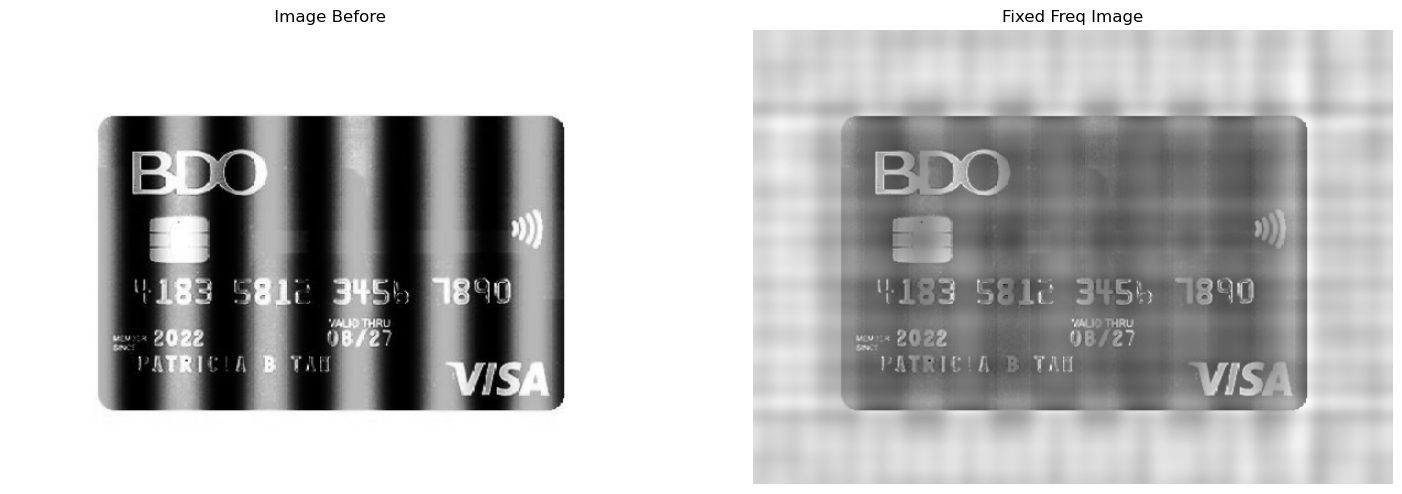

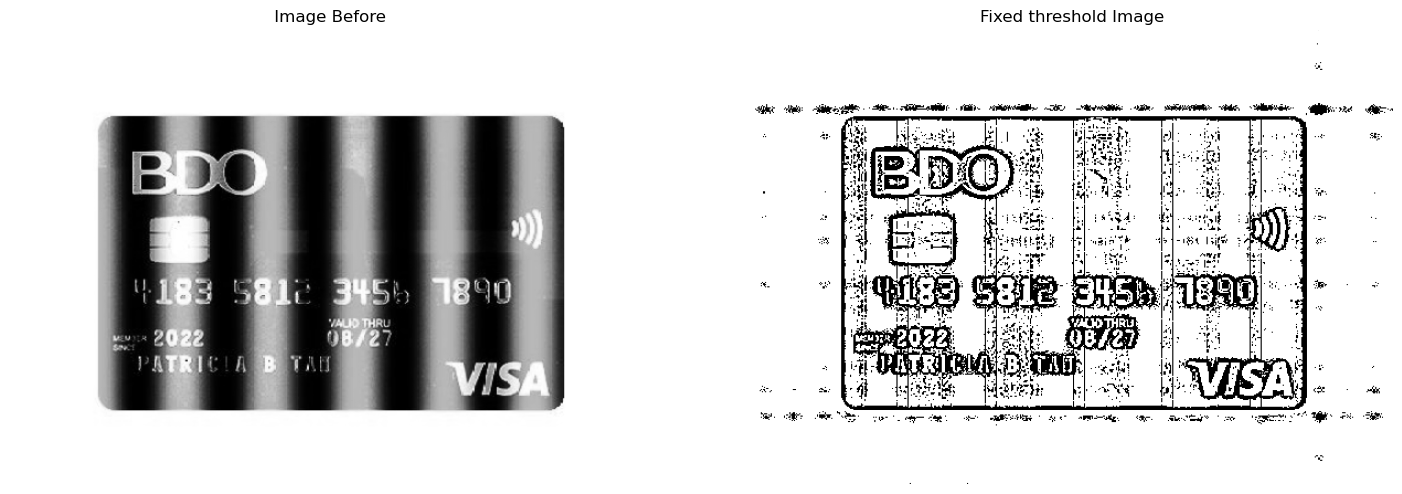

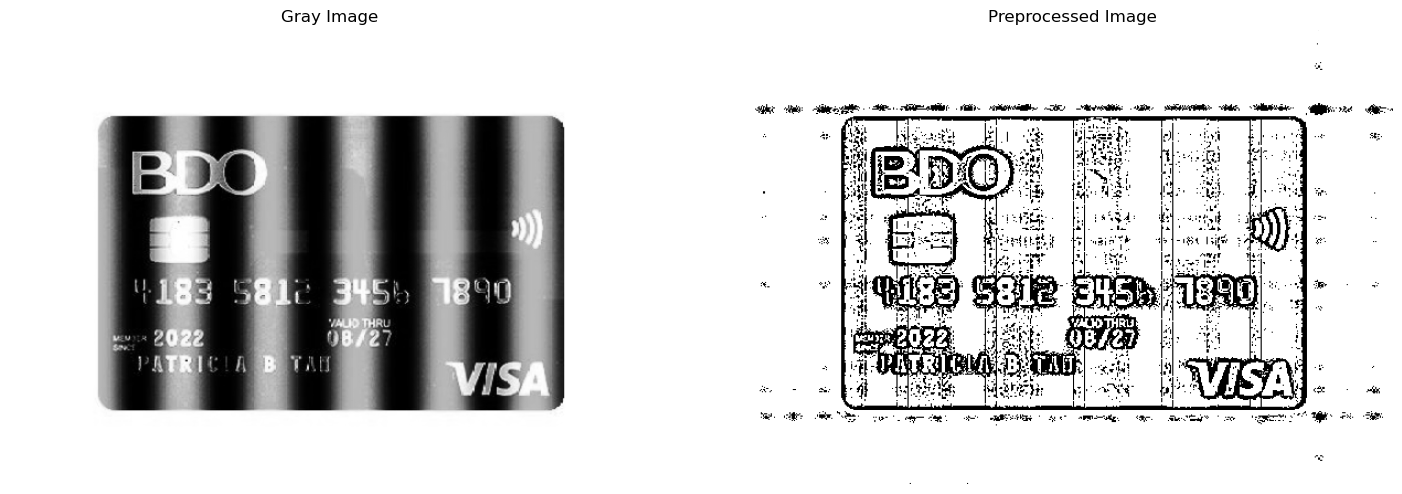

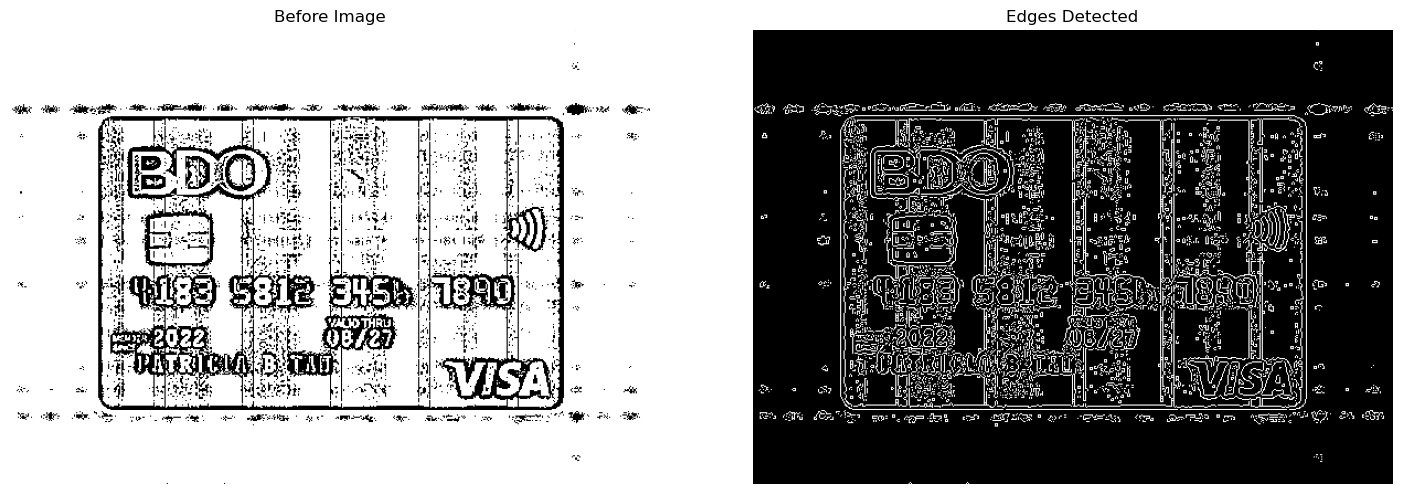

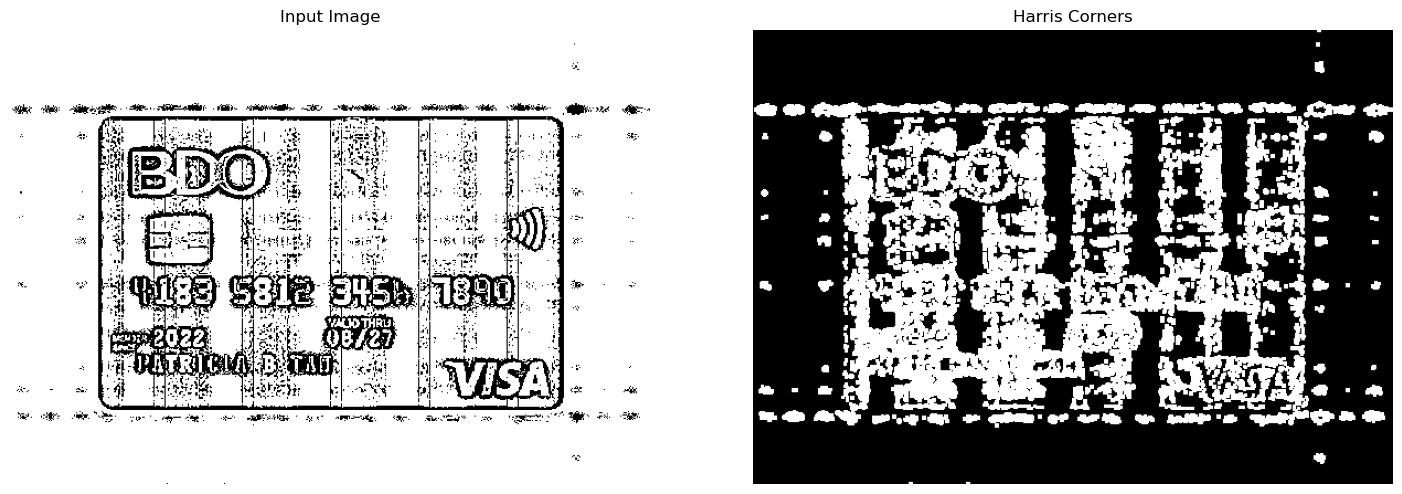

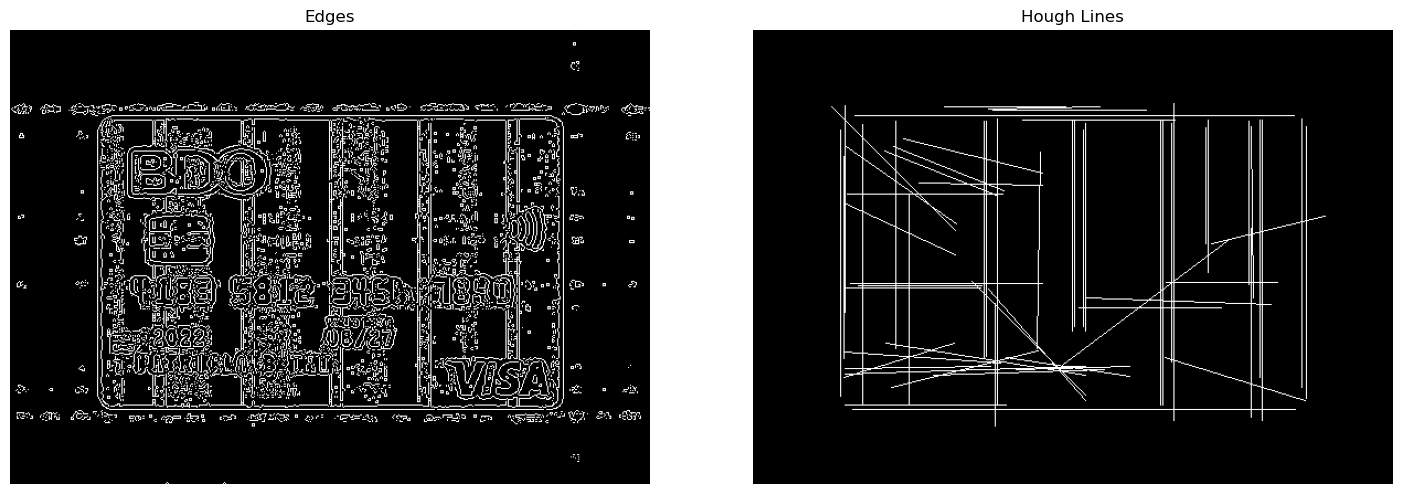

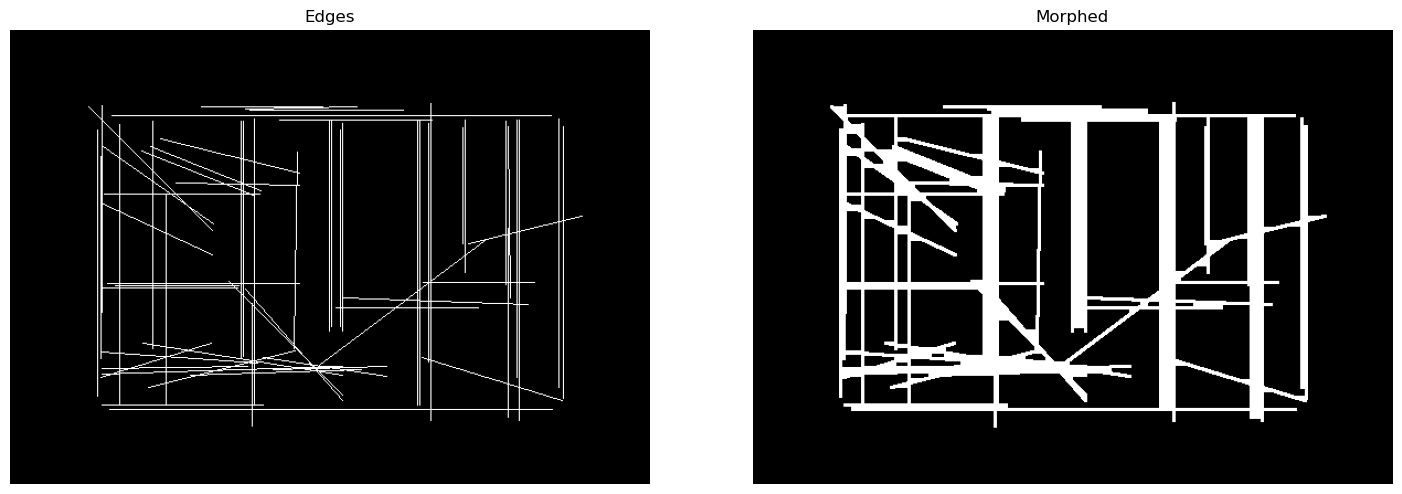

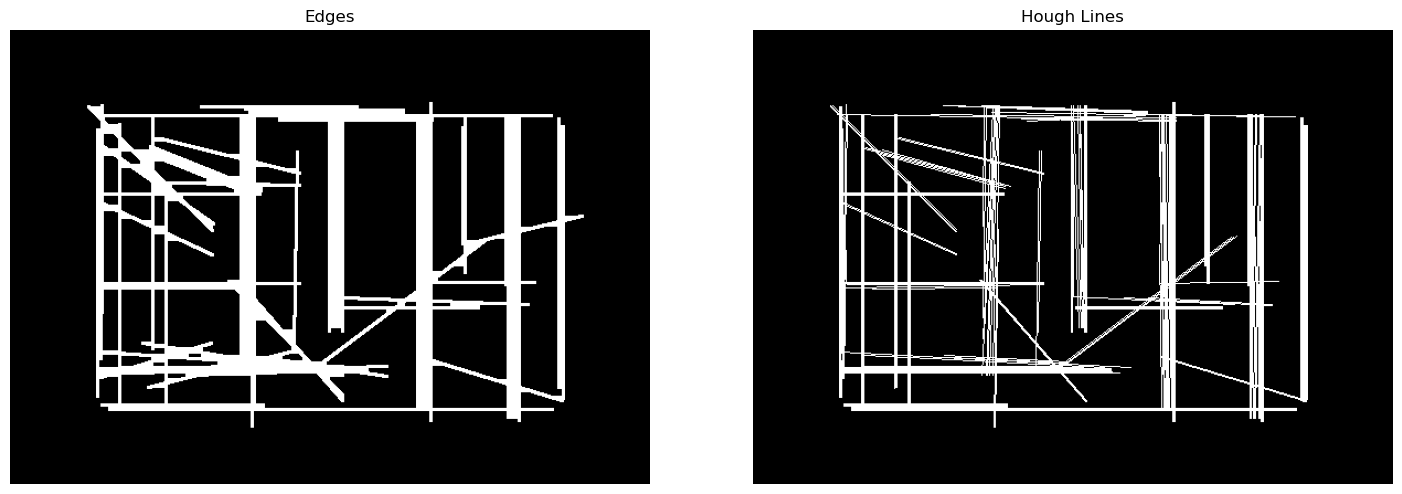

In [43]:
# for i in range(len(testcases)):
for i in range(1):
    print(f"Processing test case {i}: {testcases[12]}")
    test_image = cv2.imread(testcases[12])

    image, gray, proceed_image = preprocess_image(test_image)
    edges = edge_detection(proceed_image)
    corner = harris_corner_detection(proceed_image)
    lines, line_image = hough_line_detection(edges)
    morphed = morphological_operations(line_image)
    lines, line_image = hough_line_detection(morphed)
    
    # credit_card_contour = find_card_contour(edges, lines, corner)
    # if credit_card_contour is not None:
    #     print("Credit card contour detected.")
    #     cropped_card = crop_credit_card(image, credit_card_contour)
    #     show_images([image, cropped_card], ['Original Image', 'Cropped Credit Card'])
    # else:
    #     print("Credit card not detected.")